In [2]:
import numpy as np
import matplotlib.pyplot as plt

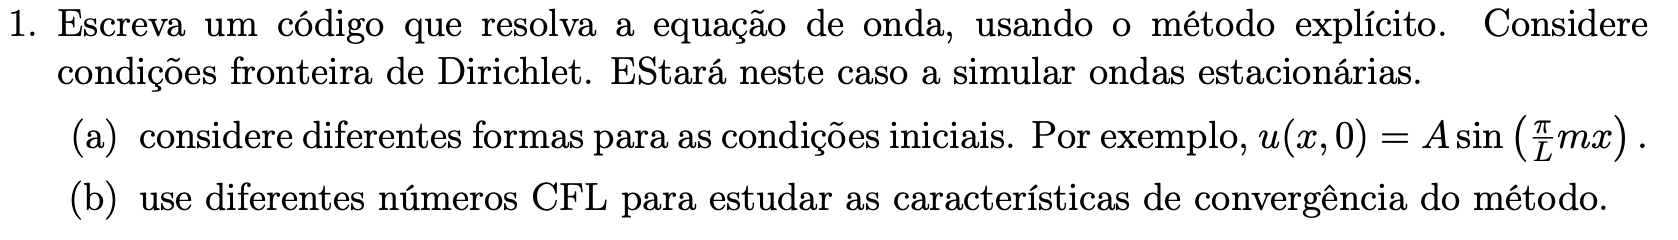

$$
u^{n+1}_i = -u^{n-1}_i + 2u^n_i + C^2
\left(u^{n}_{i+1}-2u^{n}_{i} + u^{n}_{i-1}\right),
\label{wave_pde1_step4}
\tag{3}
$$

onde definimos $C\equiv c\Delta t/ \Delta x$, e que é conhecido por número de Courant (ou de Courant-Friederichs-Lewy, CFL). Note-se que para calcular $u_i^{n+1}$, precisamos de saber $u$ em dois tempos anteriores, nomeadamente $u_i^{n}$ e $u_i^{n-1}$. Isso põe imediatamente o problema de como começar o algoritmo, pois só temos informação num tempo, $t_0=0$. Ou não? Na verdade, temos a segunda condição inicial, $u_t=0$! Para a utilizar numericamente precisamos igualmente discretizá-la. Escolhendo diferenças centrais, o que nos dá um erro de truncagem da mesma ordem dos esquemas escolhidos para as segundas derivadas, podemos escrever:

$$ u_t=0 \Rightarrow \frac{u_i^{n+1}-u_i^{n-1}}{2\Delta t} = 0 \Rightarrow u_i^{n+1}=u_i^{n-1}, \quad i=0,\ldots,N_x . \tag{4}$$

A outra condição inicial é simplesmente:

$u_i^0 = I(x_i),\;\;\;\; i=0,\ldots,N_x.$

O algoritmo pode então ser começado em $t_0=0$ alterando a fórmula geral (3) com o resultado (4):

$$
u_i^1 = u^0_i + \frac{1}{2}
C^2\left(u^{0}_{i+1}-2u^{0}_{i} + u^{0}_{i-1}\right)
\label{wave_pde1_step4_1}
\tag{5}
.$$


### Algoritmo

* calcular $u_i^0=I(x_i)$ para $i=0,\ldots,N_x$

* calcular $u^1_i$ via (5) e fazer $u^1_i=0$ para os pontos da fronteira $i=0$ e $i=N_x$,

* para cada tempo $n=1,2,\ldots,N_t-1$

    * aplicar (3)  para obter $u^{n+1}_i$ para $i=1,\ldots,N_x−1$
    
    * pôr $u^{n+1}_i=0$ para os pontos da fronteira $i=0$, $i=N_x$.



In [57]:
def initial_condition(x,*args):
    A,L,m = args
    return A * np.sin(np.pi/L * m * x)


def explicit_method(Nx,Nt,xmax,tmax,I,A,m):
    '''
    O esquema é estável para C<=1 
    '''
    

    x    = np.linspace(0., xmax, Nx+1)
    t    = np.linspace(0., tmax, Nt+1)
    # 
    dx   = x[1] - x[0]
    dt   = t[1] - t[0]

    c    = 1.
    C    = c*dt/dx            # número de Courant
    if C > 1:
        print(f'C={C}\nThe method is unstable for C>1')
        return None

    C2   = C**2              # variável auxiliar
    print('Número de Courant é %.8f' %C)

    u    = np.zeros(len(x))
    u_1  = u.copy()
    u_2  = u.copy()
    
    # Impôr condição inicial u(x,0) = I(x)
    for i in range(0, Nx+1):
        u_1[i] = I(x[i],A,xmax,m) # initial_condition(x,A,L,m)
    
    plt.figure(figsize=(7,5))
    plt.plot(x,u_1,label='Initial Condition')

    # Aplicar a fórmula especial no primeiro passo, com du/dt=0 incorporada
    for i in range(1, Nx):
        u[i] = u_1[i] + 0.5*C2*(u_1[i+1] - 2*u_1[i] + u_1[i-1])
    u[0] = 0;  u[Nx] = 0   # Impôr condições fronteira Dirichlet

    # Trocar papel das variáveis antes do próximo passo (presente passa a passado, futuro passa a presente)
    u_2[:], u_1[:] = u_1, u

    for n in range(1, Nt):
        # Actualizar todos os nodos interiores no instante t[n+1]
        for i in range(1, Nx):
            u[i] = 2*u_1[i] - u_2[i] + \
                    C2*(u_1[i+1] - 2*u_1[i] + u_1[i-1])

        # Aplicar condições fronteira
        u[0] = 0;  u[Nx] = 0

        # Trocar papel das variáveis antes do próximo passo
        u_2[:], u_1[:] = u_1, u
        
    plt.plot(x,u_1,label='fim')
    
    
    plt.ylabel('Amplitude')
    plt.xlabel('X(m)')
    plt.legend()
    plt.show()
        
    return u_1

Número de Courant é 0.53333333


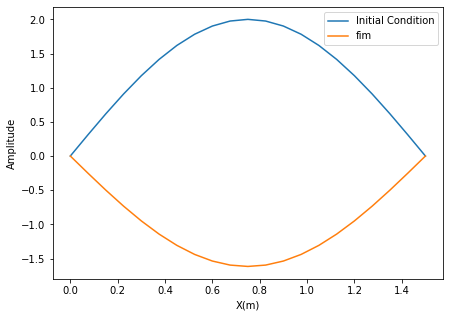

In [58]:
exp = explicit_method(20,30,1.5,1.2,initial_condition,2,1)

Número de Courant é 1.00000000


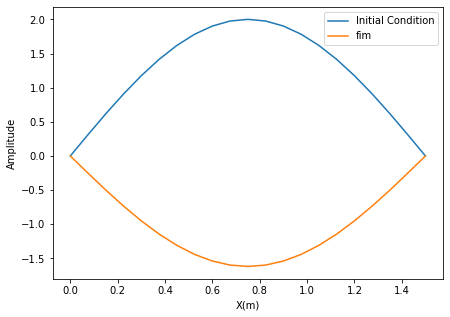

In [59]:
exp = explicit_method(20,16,1.5,1.2,initial_condition,2,1)

In [60]:
exp = explicit_method(20,10,1.5,1.2,initial_condition,2,1)

C=1.6
The method is unstable for C>1
